# AEBS - AOBxFAC_2F product

Demonstration of `AOBxFAC_2F` product.

Feel free to change the `SPACECRAFT`, `START_TIME`, and `END_TIME` paramteres and re-run the notebook.

The notebook retrieves and displays data for the selected satellite and time range.

In [1]:
#------------------------------------------------------------------------------
# User input:

SPACECRAFT = 'A'
START_TIME='2015-06-01T00:00:00Z'
END_TIME='2015-06-01T12:00:00Z'

#SERVER_URL = 'https://staging.viresdisc.vires.services/ows'
SERVER_URL = 'https://testing.vires.services/ows'

#------------------------------------------------------------------------------

from viresclient import SwarmRequest

SwarmRequest.COLLECTIONS.update({
    'AOB_FAC': ['SW_OPER_AOB{}FAC_2F'.format(x) for x in 'ABC'],
})

SwarmRequest.PRODUCT_VARIABLES.update({
    'AOB_FAC': [
        'Latitude_QD', 'Longitude_QD', 'MLT_QD',
        'Boundary_Flag', 'Quality', 'Pair_Indicator'
    ],
})

try:
    request = SwarmRequest(SERVER_URL)

    request.set_collection('SW_OPER_AOB%sFAC_2F' % SPACECRAFT)
    request.set_products(
        measurements=[
            'Latitude_QD', 'Longitude_QD', 'MLT_QD', 'Boundary_Flag',
            'Quality', 'Pair_Indicator',
        ],
        auxiliaries=['QDOrbitDirection'],
    )

    response = request.get_between(
        start_time=START_TIME,
        end_time=END_TIME,
    )
    boundaries = response.as_xarray()

    request.set_collection('SW_OPER_MAG%s_LR_1B' % SPACECRAFT)
    request.set_products(
        measurements=[],
        auxiliaries=['QDLat', 'QDLon', 'MLT'],
    )

    response = request.get_between(
        start_time=START_TIME,
        end_time=END_TIME,
    )
    orbit = response.as_xarray()
    
except Exception as error:
    print('ERROR: ', error)
else:
    print(boundaries)
    print(orbit)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.106MB)
[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (2.467MB)


<xarray.Dataset>
Dimensions:           (Quality_dim1: 2, Timestamp: 55)
Coordinates:
  * Timestamp         (Timestamp) datetime64[ns] 2015-06-01T00:02:10.500000 ... 2015-06-01T11:46:03.500000
Dimensions without coordinates: Quality_dim1
Data variables:
    Spacecraft        (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Longitude         (Timestamp) float64 -175.9 -174.9 -168.6 ... -177.0 -170.7
    Boundary_Flag     (Timestamp) uint8 2 1 1 2 2 1 1 2 2 ... 2 1 1 2 1 1 2 2 1
    QDOrbitDirection  (Timestamp) int8 1 1 1 1 -1 -1 -1 -1 ... -1 -1 1 1 1 -1 -1
    MLT_QD            (Timestamp) float64 14.57 14.36 11.87 ... 17.3 21.43 22.8
    Radius            (Timestamp) float64 6.839e+06 6.839e+06 ... 6.822e+06
    Longitude_QD      (Timestamp) float64 -73.38 -76.59 -122.9 ... -138.3 -118.5
    Pair_Indicator    (Timestamp) int8 1 -1 1 -1 1 -1 1 -1 ... 1 -1 0 1 -1 1 -1
    Quality           (Timestamp, Quality_dim1) float64 1.2 0.2778 ... 0.1847
    Latitude_QD       (Timest

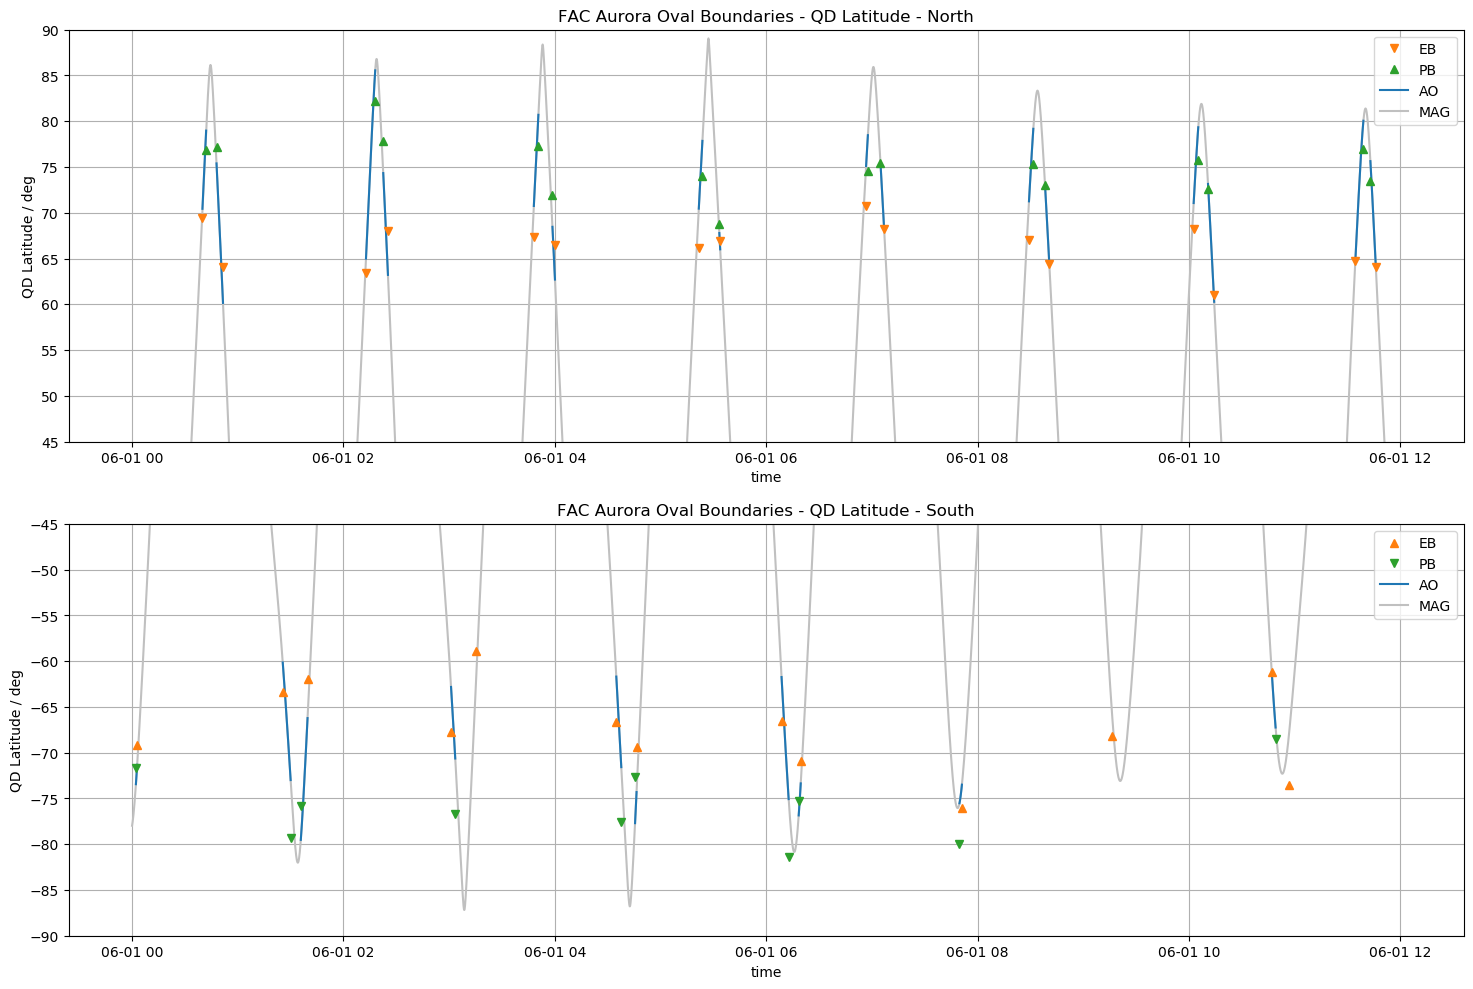

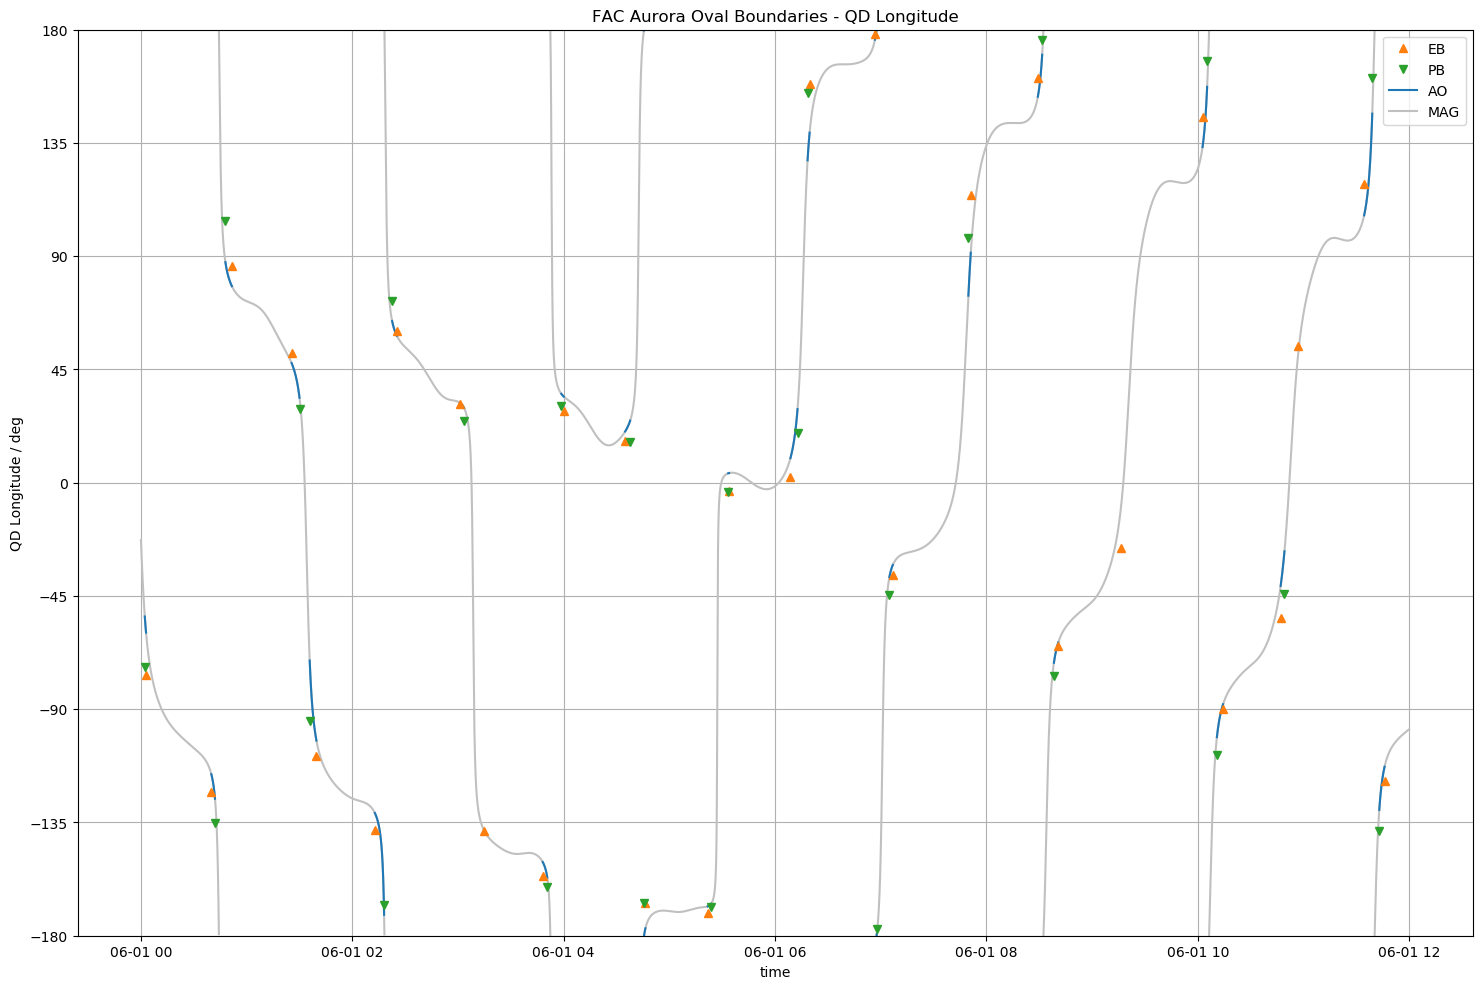

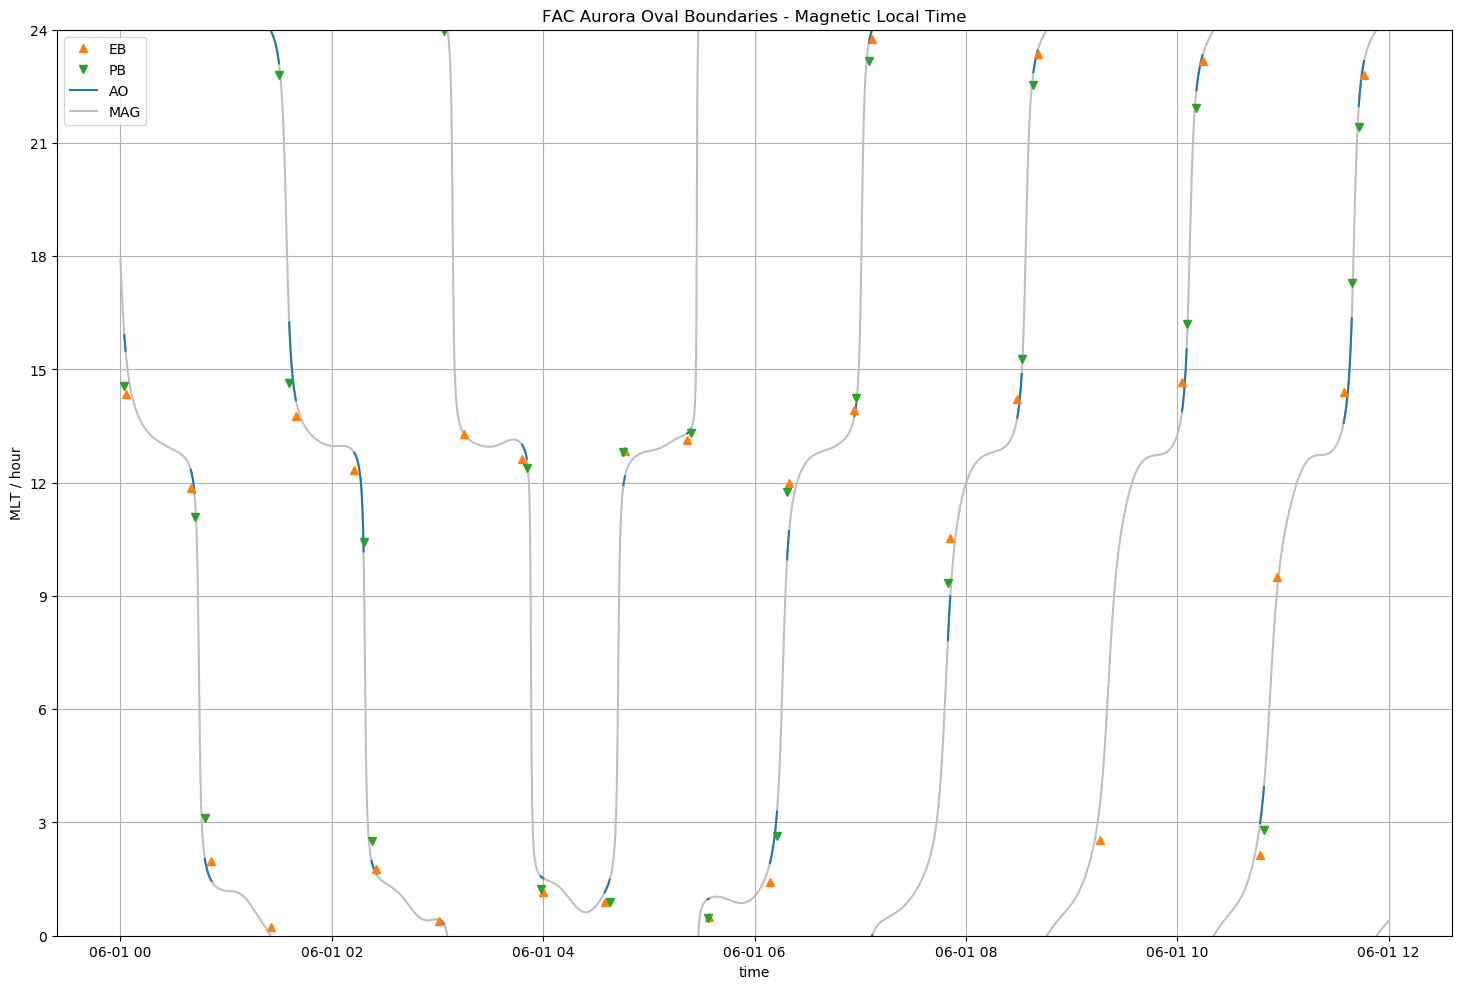

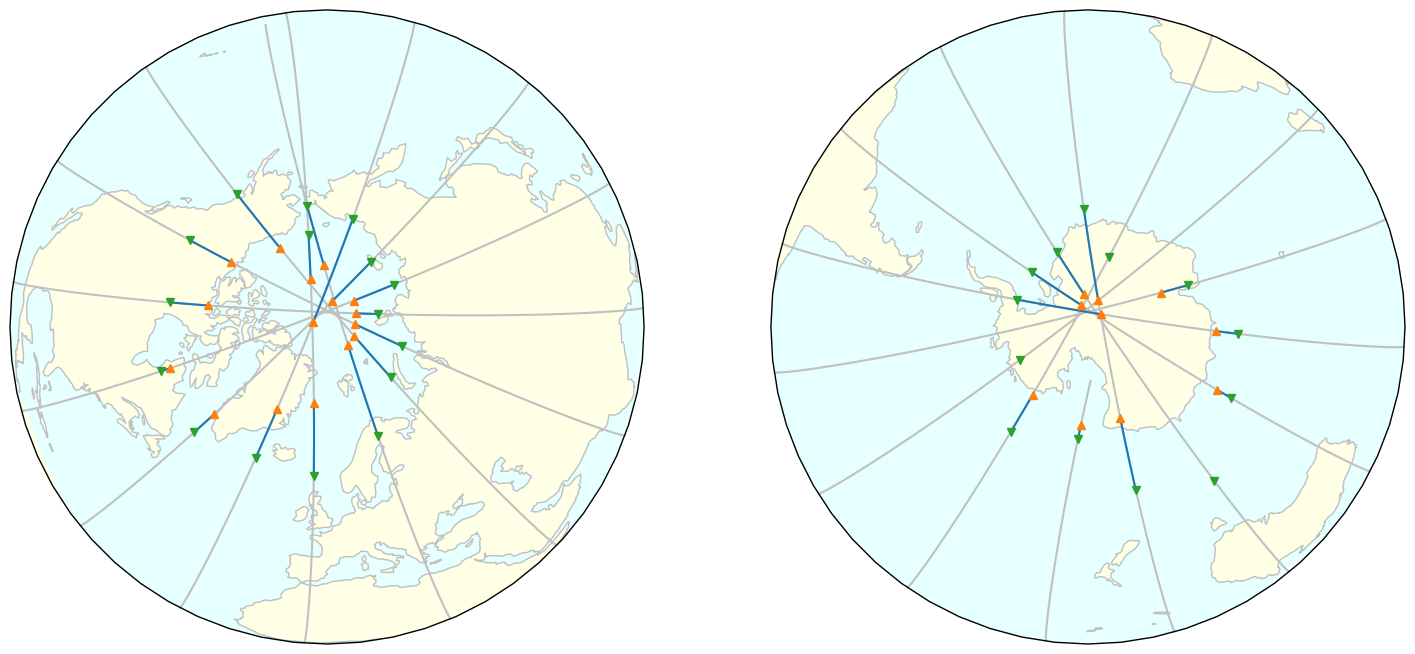

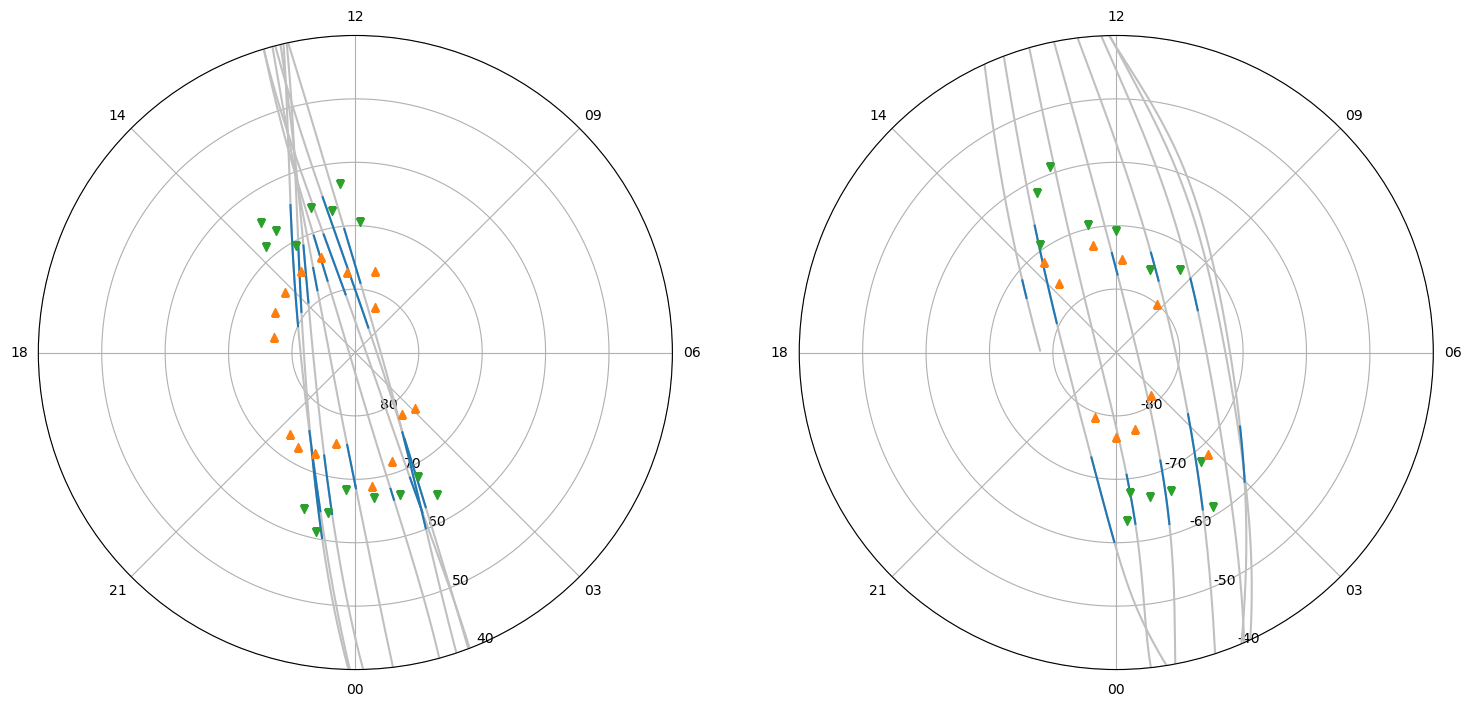

In [3]:
from numpy import isnan, logical_and, abs as aabs, cumsum, stack, pi, concatenate, timedelta64
from matplotlib.pyplot import figure, subplot, show
from scipy.interpolate import interp1d
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, Orthographic, PlateCarree
%matplotlib inline

# AOB data
b_time = boundaries['Timestamp'].values
b_lat = boundaries['Latitude'].values
b_lon = boundaries['Longitude'].values
b_lat_qd = boundaries['Latitude_QD'].values
b_lon_qd = boundaries['Longitude_QD'].values
b_mlt = boundaries['MLT_QD'].values
b_flag = boundaries['Boundary_Flag'].values
b_pair_indicator = boundaries['Pair_Indicator'].values
b_orbit_direction = boundaries['QDOrbitDirection'].values
hemisphere = (b_lat_qd > 0)*2 - 1 

b_mask_eb = b_flag == 1
b_mask_pb = b_flag == 2

idx_start, = (b_pair_indicator == +1).nonzero()
idx_end, = (b_pair_indicator == -1).nonzero()

# strip incomplete 
dsize = idx_start.size - idx_end.size 
if dsize == 0:
    if idx_start.size and idx_start[0] > idx_end[0]:
        idx_end = idx_end[1:]
        idx_start = idx_start[:-1]
elif dsize == -1: # starting point is missing
    idx_end = idx_end[1:]
elif dsize == +1: # end point is missing
    idx_start = idx_start[:-1]
else:
    raise Exception('Boundaries mismatch!')

# orbit read from MAGx_LR
o_time = orbit['Timestamp'].values
o_lat = orbit['Latitude'].values
o_lon = orbit['Longitude'].values
o_lat_qd = orbit['QDLat'].values
o_lon_qd = orbit['QDLon'].values
o_mlt = orbit['MLT'].values

# AO mask -> True if point is inside AO
o_mask_ao = interp1d(
    b_time.astype('int64'), b_pair_indicator==1, kind='zero', bounds_error=False, fill_value=0.0
)(o_time.astype('int64')).astype('bool')

idx = stack((idx_start, idx_end), axis=0)


def split_array(data, threshold, start=None, end=None):
    if start is None:
        start = 0
    if end is None:
        end = len(data)
    split = concatenate((
        [start],
        (abs(data[start+1:end] - data[start:end-1]) > threshold).nonzero()[0] + 1 + start,
        [end]
    ))
    return zip(split[:-1], split[1:])

# -----------------------------------------------------------------------------
fig = figure(figsize=(18, 12), dpi=100)

def plot_qdlat_vs_time(ax, ylim, label): 
    is_north = min(ylim) > 0
    l_orb, = ax.plot(o_time, o_lat_qd, '-', color='silver')
    for start, end in split_array(o_time[o_mask_ao], timedelta64(1, 's')):
        l_ao, = ax.plot(o_time[o_mask_ao][start:end], o_lat_qd[o_mask_ao][start:end], '-', color='tab:blue')
    l_eb, = ax.plot(b_time[b_mask_eb], b_lat_qd[b_mask_eb], 'v' if is_north else '^', color='tab:orange')
    l_pb, = ax.plot(b_time[b_mask_pb], b_lat_qd[b_mask_pb], '^' if is_north else 'v', color='tab:green')
    
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_title('FAC Aurora Oval Boundaries - QD Latitude - %s' % label)
    ax.set_ylabel('QD Latitude / deg')
    ax.set_xlabel('time')
    ax.legend((l_eb, l_pb, l_ao, l_orb), ('EB', 'PB', 'AO', 'MAG'));

plot_qdlat_vs_time(subplot(211), (45, 90), 'North')
plot_qdlat_vs_time(subplot(212), (-90, -45), 'South')

# -----------------------------------------------------------------------------

def plot_qdlon_vs_time(ax): 
    ylim = (-180, 180)
    for start, end in split_array(o_lon_qd, 180.0):
        l_orb, = ax.plot(o_time[start:end], o_lon_qd[start:end], '-', color='silver')
    for start0, end0 in split_array(o_time[o_mask_ao], timedelta64(1, 's')):
        for start, end in split_array(o_lon_qd[o_mask_ao], 180.0, start0, end0):
            l_ao, = ax.plot(o_time[o_mask_ao][start:end], o_lon_qd[o_mask_ao][start:end], '-', color='tab:blue')
    
    l_eb, = ax.plot(b_time[b_mask_eb], b_lon_qd[b_mask_eb], '^', color='tab:orange')
    l_pb, = ax.plot(b_time[b_mask_pb], b_lon_qd[b_mask_pb], 'v', color='tab:green')
    
    ax.set_ylim(ylim)
    ax.set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    ax.grid()
    ax.set_title('FAC Aurora Oval Boundaries - QD Longitude')
    ax.set_ylabel('QD Longitude / deg')
    ax.set_xlabel('time')
    ax.legend((l_eb, l_pb, l_ao, l_orb), ('EB', 'PB', 'AO', 'MAG'));

fig = figure(figsize=(18, 12), dpi=100)
plot_qdlon_vs_time(subplot(111))

# -----------------------------------------------------------------------------

def plot_mlt_vs_time(ax): 
    ylim = (0, 24)
    for start, end in split_array(o_mlt, 12.0):
        l_orb, = ax.plot(o_time[start:end], o_mlt[start:end], '-', color='silver')
    for start0, end0 in split_array(o_time[o_mask_ao], timedelta64(1, 's')):
        for start, end in split_array(o_mlt[o_mask_ao], 12.0, start0, end0):
            l_ao, = ax.plot(o_time[o_mask_ao][start:end], o_mlt[o_mask_ao][start:end], '-', color='tab:blue')
    
    l_eb, = ax.plot(b_time[b_mask_eb], b_mlt[b_mask_eb], '^', color='tab:orange')
    l_pb, = ax.plot(b_time[b_mask_pb], b_mlt[b_mask_pb], 'v', color='tab:green')
    
    ax.set_ylim(ylim)
    ax.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    ax.grid()
    ax.set_title('FAC Aurora Oval Boundaries - Magnetic Local Time')
    ax.set_ylabel('MLT / hour')
    ax.set_xlabel('time')
    ax.legend((l_eb, l_pb, l_ao, l_orb), ('EB', 'PB', 'AO', 'MAG'));

fig = figure(figsize=(18, 12), dpi=100)
plot_mlt_vs_time(subplot(111))

# -----------------------------------------------------------------------------

def plot_maps(ax, north):
    h = 1 if north else -1
    gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=0, color='silver', alpha=0.5, linestyle='--')
    ax.set_xlim([-6378073.21863, 6378073.21863])
    ax.set_ylim([-6378073.21863, 6378073.21863])
    ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(COASTLINE, edgecolor='silver')

    o_mask = o_lat*h > 0
    for start0, end0 in split_array(o_time[o_mask], timedelta64(1, 's')):
        for start, end in split_array(o_lon[o_mask], 180, start0, end0):
            ax.plot(o_lon[o_mask][start:end], o_lat[o_mask][start:end], '-', color='silver', transform=PlateCarree())

    for start0, end0 in split_array(o_time[o_mask_ao], timedelta64(1, 's')):
        for start, end in split_array(o_lon[o_mask_ao], 180, start0, end0):
            ax.plot(o_lon[o_mask_ao][start:end], o_lat[o_mask_ao][start:end], '-', color='tab:blue', transform=PlateCarree())
    ax.plot(b_lon[b_mask_eb], b_lat[b_mask_eb], 'v', color='tab:green', transform=PlateCarree())
    ax.plot(b_lon[b_mask_pb], b_lat[b_mask_pb], '^', color='tab:orange', transform=PlateCarree())
    
fig = figure(figsize=(18, 9), dpi=100)
plot_maps(subplot(1, 2, 1, projection=Orthographic(0, 90)), north=True)
plot_maps(subplot(1, 2, 2, projection=Orthographic(0, -90)), north=False)

# -----------------------------------------------------------------------------

def plot_mlt(ax, north=True):
    ax.set_theta_zero_location('S')
    h = 1 if north else -1
    
    def _plot(x, y, *args, **kwargs):
        return ax.plot(x*(pi/12), 90 - y*h, *args, **kwargs)

    o_mask = o_lat_qd*h > 0
    for start0, end0 in split_array(o_time[o_mask], timedelta64(1, 's')):
        for start, end in split_array(o_mlt[o_mask], 12, start0, end0):
            _plot(o_mlt[o_mask][start:end], o_lat_qd[o_mask][start:end], '-', color='silver')

    for start0, end0 in split_array(o_time[o_mask_ao], timedelta64(1, 's')):
        for start, end in split_array(o_mlt[o_mask_ao], 12, start0, end0):
            _plot(o_mlt[o_mask_ao][start:end], o_lat_qd[o_mask_ao][start:end], '-', color='tab:blue')
            
    _plot(b_mlt[b_mask_eb], b_lat_qd[b_mask_eb], 'v', color='tab:green')
    _plot(b_mlt[b_mask_pb], b_lat_qd[b_mask_pb], '^', color='tab:orange')
    
    ax.set_ylim(0, 50)
    ax.set_xticklabels(['%2.2i' % (x*12/pi) for x in ax.get_xticks()])
    ax.set_yticklabels(['%.0f' % ((90 - y)*h) for y in ax.get_yticks()])

fig = figure(figsize=(18, 9), dpi=100)
plot_mlt(subplot(1, 2, 1, projection='polar'), north=True)
plot_mlt(subplot(1, 2, 2, projection='polar'), north=False)